In [4]:
import pandas as pd
import numpy as np
import math
from datetime import date

from alibi_detect.cd import TabularDrift
from alibi_detect.cd import ClassifierDrift

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [5]:
#Data import: use delta lake in databricks version
df = pd.read_csv(r"D:/GitHubLocal/NHL-Game-II/Period_1_Game_Stats_Final_ModelReady(April-10th-2022).csv")

In [6]:
df.dtypes

won                        int64
Shots                    float64
Shots_Against            float64
Goals                    float64
Goals_Against            float64
Takeaways                float64
Takeaways_Against        float64
Hits                     float64
Hits_Against             float64
Blocked Shots            float64
Blocked Shots Against    float64
Giveaways                float64
Giveaways_Against        float64
Missed Shots             float64
Missed Shots_Against     float64
Penalities               float64
Penalities_Against       float64
#Won Faceoffs            float64
#Lost Faceoffs           float64
HoA_away                   int64
HoA_home                   int64
dtype: object

In [7]:
df.head()

,won,Shots,Shots_Against,Goals,Goals_Against,Takeaways,Takeaways_Against,Hits,Hits_Against,Blocked Shots,...,Giveaways,Giveaways_Against,Missed Shots,Missed Shots_Against,Penalities,Penalities_Against,#Won Faceoffs,#Lost Faceoffs,HoA_away,HoA_home
0,0,8.0,8.0,0.0,3.0,1.0,3.0,14.0,5.0,3.0,...,6.0,7.0,4.0,0.0,1.0,1.0,10.0,12.0,1,0
1,1,8.0,8.0,3.0,0.0,3.0,1.0,5.0,14.0,3.0,...,7.0,6.0,0.0,4.0,1.0,1.0,12.0,10.0,0,1
2,1,11.0,12.0,0.0,1.0,0.0,2.0,4.0,4.0,6.0,...,2.0,0.0,6.0,3.0,1.0,3.0,11.0,9.0,1,0
3,0,12.0,11.0,1.0,0.0,2.0,0.0,4.0,4.0,8.0,...,0.0,2.0,3.0,6.0,3.0,1.0,9.0,11.0,0,1
4,1,9.0,8.0,0.0,1.0,3.0,2.0,4.0,5.0,7.0,...,7.0,5.0,3.0,8.0,2.0,1.0,7.0,11.0,1,0


In [242]:
def split_ref_new(df, last_n, ref_data_n, include_target:bool = False):
    """
    Splits the main dataframe into a reference and new dataframe and np.array for drift detection
    Takes args last_n for new data and ref_data_n for reference data
    If include_target is True, also returns split y
    """
    if include_target == False:
        X_ref = np.array(df.iloc[-ref_data_n - 2:-last_n, 1:])
        df_ref = df.iloc[-ref_data_n - 2:-last_n, 1:]
        X_new = np.array(df.iloc[-last_n:, 1:])
        df_new = df.iloc[-last_n:, 1:]

        return X_ref, df_ref, X_new, df_new
    
    if include_target == True:
        X_ref = np.array(df.iloc[-ref_data_n - 2:-last_n, :])
        df_ref = df.iloc[-ref_data_n - 2:-last_n, :]
        y_ref = df.iloc[-ref_data_n - 2:-last_n,0]

        X_new = np.array(df.iloc[-last_n:, :])
        df_new = df.iloc[-last_n:, :]
        y_new = df.iloc[-last_n:, 0]

        return X_ref, df_ref, y_ref, X_new, df_new, y_new


# Feature/Data Drift

## K-S Tests

In [50]:
def plot_features(new_data, ref_data, feature_drift, drift_stats):
    """
    Plots the distribution of features in 4x... grid
    Need to add legend detailing blue = reference, red = last 60 rows
    """
    n_cols = 4
    n_rows = math.ceil((len(ref_data.columns)/4))
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    
    axs = axs.ravel()
    binwidth = 1
    for i in range(len(ref_data.columns)):
        bins = int((ref_data.iloc[:,i].max() - ref_data.iloc[:,i].min())/binwidth)
        ref_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="blue", bw_method='silverman')
        new_data.iloc[:,i].plot(kind="density", ax=axs[i], alpha=0.5, color="red", bw_method='silverman')
        
        axs[i].set_title(f'Distribution: {ref_data.columns[i]} - Drift: {feature_drift[i]}')
        
        axs[i].text(0.5,-0.2, f"K-S: {drift_stats[i][0]:.3f} -- pval: {drift_stats[i][1]:.3f}", size=12, ha="center", 
         transform=axs[i].transAxes)
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

In [54]:
def feature_KS_test(df, last_n, ref_data_n):
    """
    Takes dataframe as input, runs a TabularDrift test, prints out results and outputs graphs
    """

    #Split dataset into references
    X_ref, df_ref, X_new, df_new = split_ref_new(df, last_n, ref_data_n)
    
    #Get the feature names
    feature_names = df_ref.columns
    
    #TabularDrift: K-S tests for num features, Chi-squared for categorical
    cd = TabularDrift(p_val=0.05, x_ref = X_ref, correction = 'bonferroni')
    
    #Predict general drift
    preds = cd.predict(X_new, return_p_val=True, return_distance = True)
    labels = ['No!', 'Yes!']
    print('General Drift Detected? {}'.format(labels[preds['data']['is_drift']]))
    print("\n")
    
    
    #Predict the drift for each feature
    fpreds = cd.predict(X_new, drift_type="feature", return_p_val=True, return_distance=True)
    
    #Get drift per feature
    feature_drift = []
    drift_stats = []
    for f in range(cd.n_features):
        stat = 'K-S'
        fname = feature_names[f]
        is_drift = fpreds['data']['is_drift'][f]
        stat_val, p_val = fpreds['data']['distance'][f], fpreds['data']['p_val'][f]
        print(f'{fname} -- Drift? {labels[is_drift]} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')
        feature_drift.append(labels[is_drift])
        drift_stats.append([stat_val, p_val])
        
    #Plot feature distribs
    plot_features(df_new, df_ref, feature_drift, drift_stats)
    
    return drift_stats 

General Drift Detected? Yes!


Shots -- Drift? No! -- K-S 0.134 -- p-value 0.307
Shots_Against -- Drift? No! -- K-S 0.121 -- p-value 0.420
Goals -- Drift? No! -- K-S 0.110 -- p-value 0.546
Goals_Against -- Drift? No! -- K-S 0.068 -- p-value 0.962
Takeaways -- Drift? No! -- K-S 0.106 -- p-value 0.585
Takeaways_Against -- Drift? No! -- K-S 0.067 -- p-value 0.969
Hits -- Drift? No! -- K-S 0.095 -- p-value 0.718
Hits_Against -- Drift? No! -- K-S 0.095 -- p-value 0.718
Blocked Shots -- Drift? No! -- K-S 0.150 -- p-value 0.190
Blocked Shots Against -- Drift? Yes! -- K-S 0.260 -- p-value 0.002
Giveaways -- Drift? No! -- K-S 0.128 -- p-value 0.355
Giveaways_Against -- Drift? No! -- K-S 0.148 -- p-value 0.202
Missed Shots -- Drift? No! -- K-S 0.036 -- p-value 1.000
Missed Shots_Against -- Drift? No! -- K-S 0.126 -- p-value 0.375
Penalities -- Drift? No! -- K-S 0.070 -- p-value 0.952
Penalities_Against -- Drift? No! -- K-S 0.068 -- p-value 0.963
#Won Faceoffs -- Drift? No! -- K-S 0.142 -- p-valu

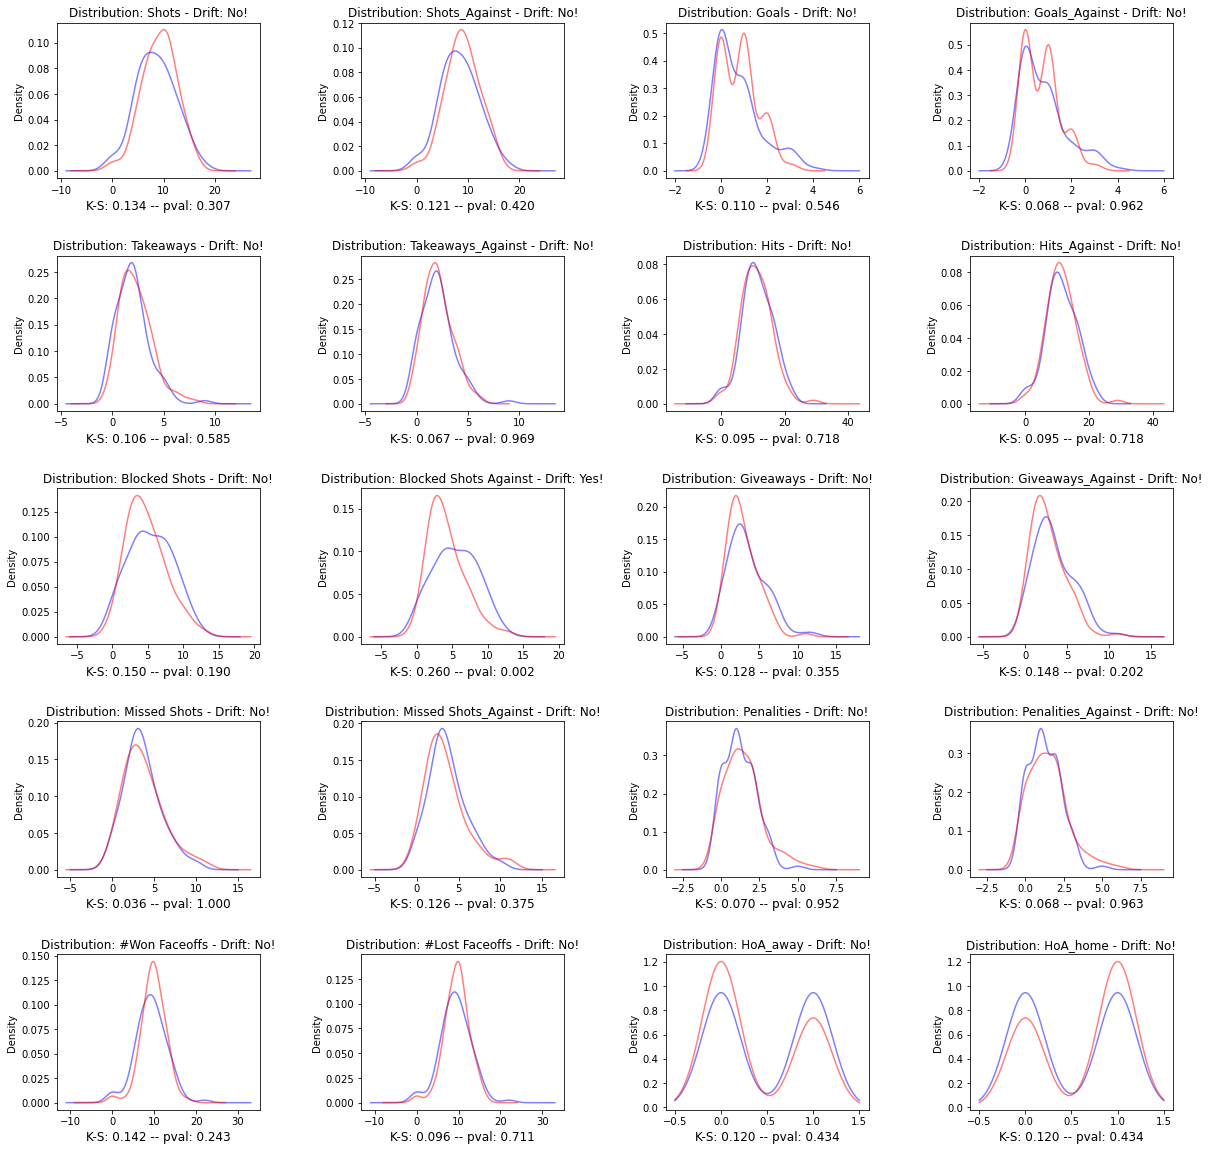

In [60]:
#Run TabularDrift detection for last 50 games compared to 100 games before that
ks_drift_stats = feature_KS_test(df, 100, 200)

In [61]:
#Store results into dataset
#Date, feature drift, score and pvalue
#First create dataframe, will change to append to existing delta lake dataframe
ks_drift_df = pd.DataFrame(columns = ["Date"] + [f"{col} Drift" for col in df.drop("won",axis=1).columns] + [f"{col} Score" for col in df.drop("won",axis=1).columns] + [f"{col} pval" for col in df.drop("won",axis=1).columns])

In [62]:
#Manipulate data into single list to add to dataframe
ks_scores, ks_pval = list(map(list, zip(*ks_drift_stats)))
ks_dummy_drift = [0 if pval > 0.05 else 1 for pval in ks_pval]
drift_list = [date.today()] + ks_dummy_drift + ks_scores + ks_pval

In [63]:
ks_drift_df.loc[len(ks_drift_df)] = drift_list

In [64]:
ks_drift_df

,Date,Shots Drift,Shots_Against Drift,Goals Drift,Goals_Against Drift,Takeaways Drift,Takeaways_Against Drift,Hits Drift,Hits_Against Drift,Blocked Shots Drift,...,Giveaways pval,Giveaways_Against pval,Missed Shots pval,Missed Shots_Against pval,Penalities pval,Penalities_Against pval,#Won Faceoffs pval,#Lost Faceoffs pval,HoA_away pval,HoA_home pval
0,2022-04-23,0,0,0,0,0,0,0,0,0,...,0.354926,0.202016,0.999999,0.375129,0.951652,0.963465,0.243379,0.711365,0.433768,0.433768


## Learned Classifier

In [180]:
def learned_classifier_drift(df, last_n, ref_data_n):
    """
    Use a learned Random Forest classifier to predict drift
    """
    X_ref, df_ref, X_new, df_new = split_ref_new(df, last_n, ref_data_n)
    
    # Define classifier
    model = RandomForestClassifier()

    # define drift detector with K-S
    detector = ClassifierDrift(
        x_ref=X_ref,
        model=model,
        backend='sklearn',
        binarize_preds=False,
        n_folds=2,
        use_calibration=True
    )
    
    labels = ['No!', 'Yes!']

    def print_preds(preds: dict, preds_name: str):
        print(preds_name)
        print('Drift? {}'.format(labels[preds['data']['is_drift']]))
        print(f'p-value: {preds["data"]["p_val"]:.3f}')
        print('')
        
        return [preds['data']['is_drift'], preds["data"]["p_val"]]
    
    output_list = print_preds(detector.predict(x=X_new), f"Last {last_n} rows")
    
    
    return output_list.insert(0, date.today())


In [181]:
lc_output = learned_classifier_drift(df, 100, 200)

Both `n_folds` and `train_size` specified. By default `n_folds` is used.
`retrain_from_scratch=True` sets automatically the parameter `warm_start=False`.
Using calibration to obtain the prediction probabilities.


Last 100 rows
Drift? No!
p-value: 0.061



In [182]:
#Store results into a dataset
lc_drift_score = pd.DataFrame(columns = ["Date", "Drift", "pval"])
lc_drift_score.loc[len(lc_drift_score)] = lc_output

C:\Users\louis\AppData\Local\Temp\ipykernel_15036\2664041418.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lc_drift_score.loc[len(lc_drift_score)] = lc_output


In [183]:
lc_drift_score

,Date,Drift,pval
0,NaN,NaN,NaN


# Statistical Summary

In [184]:
# Get the summary statistics for the new dataframe and other stats
# Mean, Var, Median, Mode, Min, Max
def get_summary_statistics(df, last_n, ref_data_n):
    """
    Function to retrieve summary statistics and other information for new dataset
    Gets the pd.describe of the new dataset
    """
    X_ref, df_ref, X_new, df_new = split_ref_new(df, last_n, ref_data_n)
    
    #Define list of stats to fetch
    stats = ["mean","var","median","mode","min","max"]

    df_stats = pd.DataFrame(columns = ["Date"] + [cols + "_" + stat for stat in stats for cols in df_new.columns])
    
    #Define empty list to store stats
    stat_list = [date.today()]
    
    #Append mean to stat_list
    stat_list = stat_list + list(df_new.mean())
    #Append var to stat_list
    stat_list = stat_list + list(df_new.var())
    #Append median to stat_list
    stat_list = stat_list + list(df_new.median())
    #Append mode to stat_list
    stat_list = stat_list + df_new.mode().values.tolist()[0]
    #Append min to stat_list
    stat_list = stat_list + list(df_new.min())
    #Append max to stat_list
    stat_list = stat_list + list(df_new.max())
    
    df_stats.loc[len(df_stats)] = stat_list
    
    return df_stats

In [185]:
df_stats_new = get_summary_statistics(df, 100, 200)

# Concept Drift

## Pearson Correlation Between y and X

In [254]:
def target_feature_correlation_drift(df, last_n, ref_data_n):
    """
    Get and plot the Pearson correlation between target 'won' and features of reference and new data.
    Allows you to check drift between main data and new data
    """
    #Split df into ref and new
    X_ref, df_ref, y_ref, X_new, df_new, y_new = split_ref_new(df, last_n, ref_data_n, include_target=True)
    
    #Get correlation for ref
    corr_ref = df_ref.drop("won", axis=1).corrwith(df_ref["won"])
    corr_new = df_new.drop("won", axis=1).corrwith(df_new["won"])
    
    #Concat into new dataframe
    df_concat = pd.concat([corr_ref.rename('Reference Data'), corr_new.rename('New Data')], axis=1)
    
    #Plot to compare in bar plot
    ax = df_concat.plot.bar(rot=65, color=['blue', 'red'], figsize=(12,12))
    
    ax.vlines(x = [0.5 + i for i in range(0,len(df_concat))], ymin = -1, ymax = 1, color = 'black', 
              linewidth=1, linestyles = 'dashed', transform=ax.get_xaxis_transform())
    ax.axhline(y=0, color='black', linewidth=0.5)
    
    plt.title("Pearson correlation of features with target")
    plt.show()
    
    #Create dataframe to store results
    sets = ["ref","new"]
    df_corr = pd.DataFrame(columns = ["Date"] + [cols + "_" + _set for _set in sets for cols in df_new.drop("won", axis=1).columns])
    
    #Add results to dataframe
    df_corr.loc[len(df_corr)] = [date.today()] + list(corr_ref) + list(corr_new)
    
    return df_corr

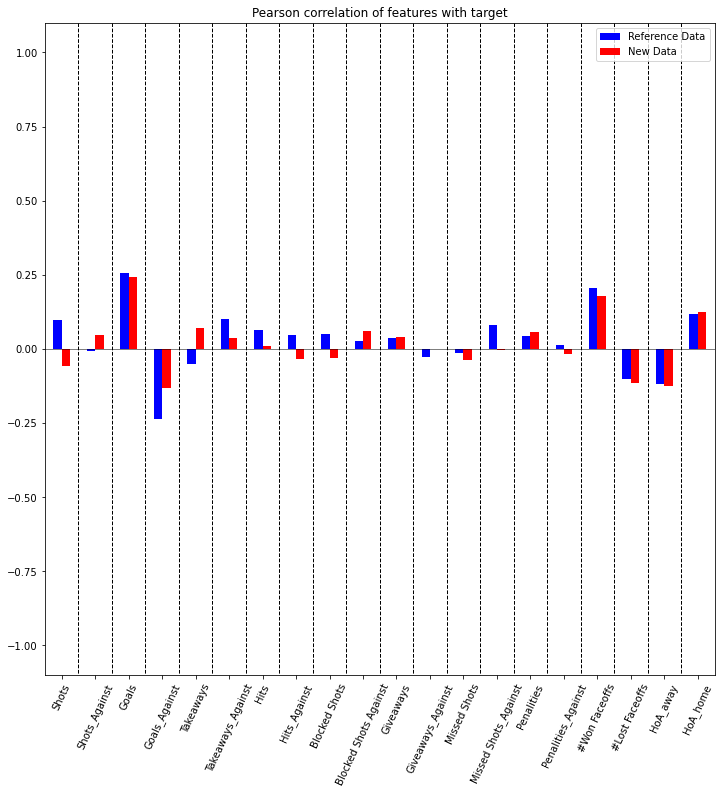

In [255]:
df_corr = target_feature_correlation_drift(df, 100, 200)

In [256]:
df_corr

,Date,Shots_ref,Shots_Against_ref,Goals_ref,Goals_Against_ref,Takeaways_ref,Takeaways_Against_ref,Hits_ref,Hits_Against_ref,Blocked Shots_ref,...,Giveaways_new,Giveaways_Against_new,Missed Shots_new,Missed Shots_Against_new,Penalities_new,Penalities_Against_new,#Won Faceoffs_new,#Lost Faceoffs_new,HoA_away_new,HoA_home_new
0,2022-04-23,0.097716,-0.008323,0.257568,-0.235807,-0.049908,0.100621,0.064482,0.046756,0.050659,...,0.041215,-4.428950e-18,-0.037029,-0.004087,0.055882,-0.015964,0.179631,-0.114071,-0.123613,0.123613
